In [46]:
import pandas as pd
import numpy as np


# Converts blue-red into win-lose
def process_data(data):
    """Vectorized processing of a single dataframe"""
    blue_wins = data['blueWin'] == 1
    
    # Initialize new dataframe with common columns
    new_df = data[['matchID', 'fullTimeMS', 'timePercent']].copy()
    
    # Define core metrics to process
    metrics = [
        'ChampionKill',
        'DragonKill',
        'DragonElderKill',
        'RiftHeraldKill',
        'BaronKill',
        'TowerKill',
        'InhibitorKill',
        'TotalGold'
    ]
    
    # Process combined minions
    new_df['winnerMinionsKilled'] = np.where(
        blue_wins,
        data['blueMinionsKilled'] + data['blueJungleMinionsKilled'],
        data['redMinionsKilled'] + data['redJungleMinionsKilled']
    )
    new_df['loserMinionsKilled'] = np.where(
        blue_wins,
        data['redMinionsKilled'] + data['redJungleMinionsKilled'],
        data['blueMinionsKilled'] + data['blueJungleMinionsKilled']
    )
    
    # Process all core metrics
    for metric in metrics:
        new_df[f'winner{metric}'] = np.where(
            blue_wins,
            data[f'blue{metric}'],
            data[f'red{metric}']
        )
        new_df[f'loser{metric}'] = np.where(
            blue_wins,
            data[f'red{metric}'],
            data[f'blue{metric}']
        )
    
    return new_df

# Main processing
data_subsets = {
    '20': 'full_data_20.csv',
    '40': 'full_data_40.csv',
    '60': 'full_data_60.csv',
    '80': 'full_data_80.csv',
    '100': 'full_data_100.csv'
}

# Dictionary to store processed DataFrames
processed_datasets = {}

for subset_label, file_path in data_subsets.items():
    print(f"Processing {subset_label}% subset")
    raw_data = pd.read_csv(file_path)
    processed_data = process_data(raw_data)
    
    # Add subset label as a column for reference
    processed_data['subset'] = subset_label
    
    # Store in dictionary
    processed_datasets[subset_label] = processed_data

# Example usage:
print(f"Available subsets: {list(processed_datasets.keys())}")
print("\n20% subset head:")
print(processed_datasets['20'].head())
print("\n100% subset info:")
print(processed_datasets['100'].head())

# If you need one combined DataFrame:
combined_df = pd.concat(processed_datasets.values(), ignore_index=True)

Processing 20% subset
Processing 40% subset
Processing 60% subset
Processing 80% subset
Processing 100% subset
Available subsets: ['20', '40', '60', '80', '100']

20% subset head:
          matchID  fullTimeMS  timePercent  winnerMinionsKilled  \
0  BR1_2720891721     2092233            6                  109   
1  BR1_2720337066     1867984            6                  131   
2  BR1_2720218416     2396948            7                  162   
3  BR1_2720199652     1656791            5                  117   
4  BR1_2720058177     1875549            6                  119   

   loserMinionsKilled  winnerChampionKill  loserChampionKill  \
0                  87                   5                  3   
1                 114                   3                  1   
2                 130                   3                  1   
3                 111                   2                  1   
4                 120                   5                  2   

   winnerDragonKill  loserDragon

In [47]:
from sklearn.preprocessing import MinMaxScaler

def create_gold_labels(data_dict):
    subsets = sorted(data_dict.keys(), key=lambda x: int(x))
    
    metrics = [
        'winnerChampionKill',
        'winnerDragonKill',
        'winnerDragonElderKill',
        'winnerRiftHeraldKill',
        'winnerBaronKill',
        'winnerTowerKill',
        'winnerInhibitorKill',
        'winnerTotalGold',
        'winnerMinionsKilled'
    ]
    
    label_map = {
        'winnerChampionKill': 'Kills',
        'winnerDragonKill': 'Dragons',
        'winnerDragonElderKill': 'Elder Dragon',
        'winnerRiftHeraldKill': 'Herald',
        'winnerBaronKill': 'Baron',
        'winnerTowerKill': 'Towers',
        'winnerInhibitorKill': 'Inhibitors',
        'winnerTotalGold': 'Gold',
        'winnerMinionsKilled': 'Minions'
    }

    all_possible_labels = list(label_map.values())

    gold_labels = {}
    label_encoder = LabelEncoder()
    label_encoder.fit(all_possible_labels)

    for i, subset in enumerate(subsets):
        current_data = data_dict[subset]
        
        # Create DataFrame to store results (preserves matchID and order)
        result_df = pd.DataFrame(index=current_data.index)
        
        if subset == '20':
            # For 20%: curr - 0
            differences = current_data[metrics].values
        else:
            # For others: curr - prev
            prev_data = data_dict[subsets[i-1]]

            # Since match IDs are in same order, we can directly subtract
            current_values = current_data[metrics].values
            prev_values = prev_data[metrics].values  # Direct access in same order

            # Calculate differences (current - previous)
            differences = current_values - prev_values
        
        # Normalize and label
        scaler = MinMaxScaler()
        normalized = scaler.fit_transform(differences)
        
        # Store results
        result_df['gold_label'] = [label_map[metrics[np.argmax(row)]] for row in normalized]

        gold_labels[subset] = result_df

    return gold_labels, label_encoder

In [ ]:
# Usage Example:
gold_labels_final, label_encoder_final = create_gold_labels(processed_datasets)

# Access labels for 40% subset:
labels_40 = gold_labels_final['40']
print(labels_40.head())

labels_80 = gold_labels_final['80']
print(labels_80.head())

  gold_label
0    Dragons
1    Dragons
2    Minions
3     Herald
4    Dragons
  gold_label
0     Towers
1      Kills
2    Dragons
3    Dragons
4      Kills


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# min/max scale the preprocessed data
scaler = MinMaxScaler()
# print(processed_datasets['20'].head(3))

metrics = [
    'ChampionKill',
    'DragonKill',
    'DragonElderKill',
    'RiftHeraldKill',
    'BaronKill',
    'TowerKill',
    'InhibitorKill',
    'TotalGold',
    'MinionsKilled'
]


# WILL NOT WORK TWICE IN A ROW
subsets = sorted(processed_datasets.keys(), key=lambda x: int(x))
for i, subset in enumerate(subsets):
    current_data = processed_datasets[subset]
    
    # Create DataFrame to store results (preserves matchID and order)
    result_df = pd.DataFrame(index=current_data.index)
    

    # Calculate differences (winner-loser)
    for metric in metrics:
        result_df[f'{metric}diff'] = current_data[f'winner{metric}'] - current_data[f'loser{metric}']
    


    # Normalize and label
    scaler = MinMaxScaler()
    result_df[result_df.columns] = scaler.fit_transform(result_df[result_df.columns])
    
    # Set new dataframe in place of old
    processed_datasets[subset] = result_df


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
# split into train/test



# Dictionary to store processed DataFrames
train_test_dict = {
    '20':{},
    '40':{},
    '60':{},
    '80':{},
    '100':{}
}

for i, subset in enumerate(subsets):
    current_data = processed_datasets[subset]
    current_gold = gold_labels_final[subset]

    data_array = np.array(current_data)
    gold_array = np.array(current_gold)

    X_train, X_test, y_train, y_test = train_test_split(data_array, gold_array, test_size=.2, random_state=42)

    new_dict = {'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test}
    train_test_dict[subset] = new_dict 


print(train_test_dict['20'])



{'X_train': array([[0.625     , 1.        , 0.        , ..., 0.        , 0.60924264,
        0.42201835],
       [0.5       , 0.5       , 0.        , ..., 0.        , 0.57988761,
        0.63302752],
       [0.54166667, 0.5       , 0.        , ..., 0.        , 0.6161201 ,
        0.52293578],
       ...,
       [0.5       , 0.5       , 0.        , ..., 0.        , 0.55883586,
        0.55963303],
       [0.29166667, 0.5       , 0.        , ..., 0.        , 0.35351841,
        0.41284404],
       [0.54166667, 0.5       , 0.        , ..., 0.        , 0.56722301,
        0.44036697]]), 'X_test': array([[0.625     , 0.5       , 0.        , ..., 0.        , 0.74159188,
        0.69724771],
       [0.54166667, 0.5       , 0.        , ..., 0.        , 0.61310073,
        0.64678899],
       [0.5       , 0.5       , 0.        , ..., 0.        , 0.54415835,
        0.51376147],
       ...,
       [0.54166667, 0.5       , 0.        , ..., 0.        , 0.5652101 ,
        0.55045872],
       [0.58

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.datasets import load_iris
# from sklearn.preprocessing import StandardScaler


# # Create an MLPClassifier model
# mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, activation='relu', solver='adam', random_state=42)

# for key in train_test_dict.keys():
#   # print(key)
#   subset = train_test_dict[key]
#   # print(subset)

#   # Train the model
#   mlp.fit(subset['X_train'], subset['y_train'])

#   # Make predictions on the test set
#   y_pred = mlp.predict(subset['X_test'])

#   # Evaluate the model
#   accuracy = accuracy_score(subset['y_test'], y_pred)
#   print(f"Accuracy {key}%: {accuracy}")

/Users/shaylawalley/miniconda3/envs/AI/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shaylawalley/miniconda3/envs/AI/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/Users/shaylawalley/miniconda3/envs/AI/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy 20%: 0.807001239157373


In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder

def prepare_rnn_data(train_test_dict, batch_size=32):
    tensor_dict = {}
    
    for subset in train_test_dict.keys():
        data = train_test_dict[subset]
        gold_labels = gold_labels_final[subset]
        
        # Convert to tensors
        X_train = torch.FloatTensor(data['X_train']).unsqueeze(1)
        X_test = torch.FloatTensor(data['X_test']).unsqueeze(1)
        
        # Get corresponding gold labels
        # Since X_train/X_test are already split, we'll match by length
        y_train = torch.LongTensor(label_encoder_final.transform(data['y_train'].flatten()))
        y_test = torch.LongTensor(label_encoder_final.transform(data['y_test'].flatten()))
        
        # Verify lengths match
        assert len(X_train) == len(y_train), f"Train length mismatch in {subset}: X={len(X_train)}, y={len(y_train)}"
        assert len(X_test) == len(y_test), f"Test length mismatch in {subset}: X={len(X_test)}, y={len(y_test)}"
        # Create datasets
        train_dataset = TensorDataset(X_train, y_train)
        test_dataset = TensorDataset(X_test, y_test)
        
        tensor_dict[subset] = {
            'train_loader': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            'test_loader': DataLoader(test_dataset, batch_size=batch_size, shuffle=False),
            'label_encoder': label_encoder_final
        }
    
    return tensor_dict

# Example usage
tensor_data = prepare_rnn_data(train_test_dict, batch_size=64)

# Access 20% data loaders
train_loader_20 = tensor_data['20']['train_loader']
test_loader_20 = tensor_data['20']['test_loader']


In [80]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    # Get all possible class indices
    all_classes = np.arange(len(class_names))
    
    # Compute confusion matrix (forcing all classes to be represented)
    cm = confusion_matrix(y_true, y_pred, labels=all_classes, normalize='true')
    
    # Reverse the order of predicted classes (columns)
    cm = cm[:, ::-1]
    
    # Create figure
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
    plt.title(title, fontsize=16)
    plt.colorbar(label='Percentage', fraction=0.046, pad=0.04)
    
    # Reverse the class names for x-axis
    reversed_class_names = class_names[::-1]
    
    # Add labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, reversed_class_names, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, class_names, fontsize=12)
    plt.xlabel('Predicted Label (Reversed)', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    
    # Add text annotations
    threshold = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = 'white' if cm[i, j] > threshold else 'black'
            percentage = f'{cm[i, j]*100:.1f}%'
            plt.text(j, i, percentage,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color=color,
                    fontsize=10)
    
    plt.tight_layout()
    plt.show()


Evaluation for 20% subset:
Accuracy: 0.8010
Weighted Precision: 0.7609
Weighted Recall: 0.8010
Weighted F1-Score: 0.7630


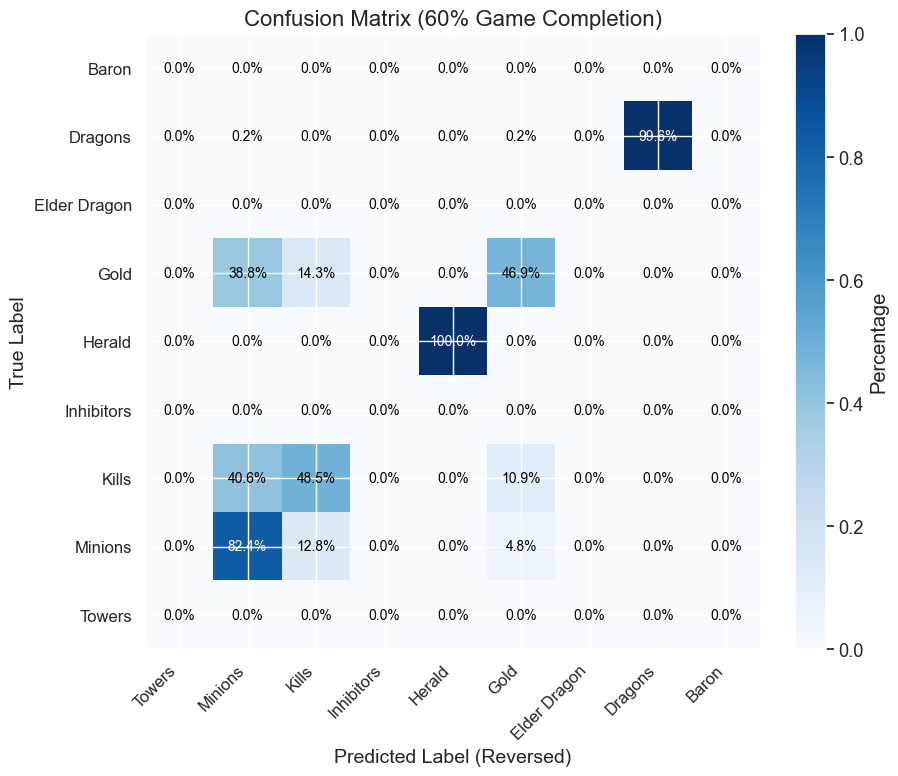

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)

class GoldLabelRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super(GoldLabelRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer (could also use LSTM or GRU)
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

def train_model(train_loader, test_loader, input_size, num_classes, device='cpu'):
    # Hyperparameters
    hidden_size = 128
    num_layers = 4
    learning_rate = 0.001
    num_epochs = 5
    
    # Initialize model
    model = GoldLabelRNN(input_size, hidden_size, num_classes, num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_true = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_true.extend(batch_y.cpu().numpy())
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(test_loader)
        val_acc = accuracy_score(all_true, all_preds)
        
        # print(f'Epoch {epoch+1}/{num_epochs}')
        # print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    return model

if __name__ == "__main__":
    # Get processed data
    tensor_data = prepare_rnn_data(train_test_dict, batch_size=64)
    
    for key in train_test_dict.keys():
        train_loader = tensor_data[key]['train_loader']
        test_loader = tensor_data[key]['test_loader']
        label_encoder = tensor_data[key]['label_encoder']
        
        # Determine model parameters
        input_size = train_test_dict[key]['X_train'].shape[1]  # Number of features
        num_classes = len(label_encoder.classes_)
        
        # Train model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = train_model(train_loader, test_loader, input_size, num_classes, device)
    
        # Full evaluation
        model.eval()
        all_preds = []
        all_true = []
        
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_true.extend(y.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_true, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_true, all_preds, average='weighted', zero_division=0
        )
        
        print(f"\nEvaluation for {key}% subset:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Weighted Precision: {precision:.4f}")
        print(f"Weighted Recall: {recall:.4f}")
        print(f"Weighted F1-Score: {f1:.4f}")
        
        class_names = label_encoder.classes_
        # Plot confusion matrix
        plot_confusion_matrix(
            all_preds,
            all_true,
            class_names,
            title=f'Confusion Matrix ({subset}% Game Completion)'
        )